<a href="https://colab.research.google.com/gist/cordmaur/50db0a00792c090e5a5cfcebede58b9e/copy-of-earthsurfacewater_torchgeo_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Earth Water Surface Tutorial

Author: Mauricio Cordeiro<br>
LinkedIn: https://www.linkedin.com/in/cordmaur/<br>
Medium: https://cordmaur.medium.com/



## Introduction

The objective of this tutorial is to go through the Earth Water Surface dataset and cover the following topics:
* Creating RasterDatasets, DataLoaders and Samplers for images and masks;
* Intersection Dataset;
* Normalizing the data;
* Creating spectral indices;
* Creating the segmentation model (DeepLabV3);
* Loss function and metrics; and
* Training loop.

> This tutorial is also available as a 3 parts Medium story: <br>https://medium.com/towards-data-science/artificial-intelligence-for-geospatial-analysis-with-pytorchs-torchgeo-part-1-52d17e409f09

## Environment

For the environment, we will install torchgeo and rasterio packages.

In [ ]:
%pip install rasterio -q
%pip install torchgeo -q

     |████████████████████████████████| 20.9 MB 83.3 MB/s 
     |████████████████████████████████| 279 kB 8.0 MB/s 
     |████████████████████████████████| 551 kB 77.5 MB/s 
     |████████████████████████████████| 16.6 MB 59.9 MB/s 
     |████████████████████████████████| 79 kB 10.8 MB/s 
     |████████████████████████████████| 1.0 MB 66.5 MB/s 
     |████████████████████████████████| 19.1 MB 1.2 MB/s 
     |████████████████████████████████| 102 kB 14.2 MB/s 
     |████████████████████████████████| 800 kB 75.2 MB/s 
     |████████████████████████████████| 9.4 MB 74.3 MB/s 
     |████████████████████████████████| 376 kB 82.9 MB/s 
     |████████████████████████████████| 419 kB 87.7 MB/s 
     |████████████████████████████████| 7.8 MB 61.3 MB/s 
     |████████████████████████████████| 965 kB 72.0 MB/s 
     |████████████████████████████████| 295 kB 75.3 MB/s 
     |████████████████████████████████| 117 kB 86.9 MB/s 
     |████████████████████████████████| 125 kB 79.3 MB/s 
     |████████



> OBS: Kernel must be restarted after install. To do this we will force the kernel to shutdown. 



## Dataset

The dataset we will use is the Earth Surface Water dataset [1] (licensed under Creative Commons Attribution 4.0 International Public License), which has patches from different parts of the world (Figure below) and its corresponding water masks. The dataset uses optical imagery from Sentinel-2 satellite with 10m of spatial resolution.

![Image](https://raw.githubusercontent.com/xinluo2018/WatNet/main/figures/dataset.png)

[1] Xin Luo. (2021). Earth Surface Water Dataset [Data set]. Zenodo. https://doi.org/10.5281/zenodo.5205674




In [ ]:
!wget https://zenodo.org/record/5205674/files/dset-s2.zip

--2022-12-15 08:04:56--  https://zenodo.org/record/5205674/files/dset-s2.zip
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 611792578 (583M) [application/octet-stream]
Saving to: ‘dset-s2.zip’

dset-s2.zip         100%[===================>] 583.45M  8.30MB/s    in 13m 4s  

2022-12-15 08:18:03 (762 KB/s) - ‘dset-s2.zip’ saved [611792578/611792578]



In [ ]:
!unzip dset-s2.zip


Archive:  dset-s2.zip
   creating: dset-s2/
  inflating: __MACOSX/._dset-s2      
   creating: dset-s2/tra_truth/
   creating: dset-s2/val_truth/
   creating: dset-s2/tra_scene/
   creating: dset-s2/val_scene/
  inflating: dset-s2/tra_truth/S2A_L2A_20190817_N0213_R089_S1_Truth.tif  
  inflating: dset-s2/tra_truth/S2B_L2A_20190818_N0213_R035_S1_Truth.tif  
  inflating: dset-s2/tra_truth/S2A_L2A_20190716_N0213_R063_S3_Truth.tif  
  inflating: dset-s2/tra_truth/S2A_L2A_20190314_N0211_R008_S1_Truth.tif  
  inflating: dset-s2/tra_truth/S2B_L2A_20190807_N0213_R018_S2_Truth.tif  
  inflating: dset-s2/tra_truth/S2B_L2A_20190904_N0213_R132_S2_Truth.tif  
  inflating: dset-s2/tra_truth/S2A_L2A_20190811_N0213_R013_S2_Truth.tif  
  inflating: dset-s2/tra_truth/S2B_L2A_20190506_N0212_R126_S3_Truth.tif  
  inflating: dset-s2/tra_truth/S2A_L2A_20190206_N0211_R067_S1_Truth.tif  
  inflating: dset-s2/tra_truth/S2A_L2A_20190125_N0211_R034_S1_Truth.tif  
  inflating: dset-s2/tra_truth/S2B_L2A_20191023_N0

## Imports

In [ ]:
from pathlib import Path
from typing import Iterable, List
import matplotlib.pyplot as plt

import rasterio as rio

from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples
from torchgeo.samplers import RandomGeoSampler, Units
from torchgeo.transforms import indices
from torch.utils.data import DataLoader
import torch


In [ ]:
import logging
# this line is to avoid warnings from Rasterio to be printed on screen
# the warning is explained here: https://stackoverflow.com/questions/74089170/suppress-rasterio-warning-warning-1-tiffreaddirectory
logger = logging.getLogger("rasterio")
logger.setLevel(logging.ERROR)

In [ ]:
root = Path('dset-s2')
assert root.exists()

## Creating the Datasets

Now that we have the original dataset already uncompressed in Colab’s environment, we can prepare it to be loaded into a neural network. For that, we will create an instance of the RasterDataset class, provided by TorchGeo, and point to the specific directory, using the following commands. The `scale` function will apply the `1e-4`  scale necessary to get the Sentinel-2 values in reflectance. Once the datasets are created, we can combine images with masks (labels) using the `&` operator.

In [ ]:
def scale(item: dict):
    item['image'] = item['image'] / 10000
    return item

In [ ]:
train_imgs = RasterDataset(root=(root/'tra_scene').as_posix(), crs='epsg:3395', res=10, transforms=scale)
train_msks = RasterDataset(root=(root/'tra_truth').as_posix(), crs='epsg:3395', res=10)

valid_imgs = RasterDataset(root=(root/'val_scene').as_posix(), crs='epsg:3395', res=10, transforms=scale)
valid_msks = RasterDataset(root=(root/'val_truth').as_posix(), crs='epsg:3395', res=10)

# IMPORTANT
train_msks.is_image = False
valid_msks.is_image = False

train_dset = train_imgs & train_msks
valid_dset = valid_imgs & valid_msks

train_sampler = RandomGeoSampler(train_imgs, size=512, length=130, units=Units.PIXELS)
valid_sampler = RandomGeoSampler(valid_imgs, size=512, length=64, units=Units.PIXELS)


Note that we are specifying the CRS (Coordinate Reference System) to EPSG:3395. TorchGeo requires that all the images are loaded in the same CRS. However, the patches in the dataset are in different UTM projections and the default behavior of TorchGeo is to use the first CRS found as its default. In this case, we have to inform a CRS that is able to cope with these different regions around the globe. To minimize the deformations due to the huge differences in latitude (I can create a history specific for this purpose) within the patches, I have selected World Mercator as the main CRS for the project. Figure 3 shows the world projected in World Mercator CRS.
![Image](https://miro.medium.com/max/4800/1*sUdRKEfIAbm79jpB3bCShQ.webp)

### Understanding the sampler

To create training patches that can be fed into a neural network from our dataset, we need to select samples of fixed sizes. TorchGeo has many samplers, but here we will use the `RandomGeoSampler` class. Basically, the sampler selects random bounding boxes of fixed size that belongs to the original image. Then, these bounding boxes are used in the `RasterDataset` to query the portion of the image we want. Here is an exmple using the previously created samplers.

In [ ]:
bbox = next(iter(train_sampler))
bbox

BoundingBox(minx=11064441.30670993, maxx=11069561.30670993, miny=6618721.839165852, maxy=6623841.839165852, mint=0.0, maxt=9.223372036854776e+18)

In [ ]:
sample = train_dset[bbox]
sample.keys()

dict_keys(['image', 'crs', 'bbox', 'mask'])

In [ ]:
sample['image'].shape, sample['mask'].shape

(torch.Size([6, 512, 512]), torch.Size([1, 512, 512]))

Notice we have now patches of same size (..., 512 x 512)

## Creating Dataloaders

Creating a `DataLoader` in TorchGeo is very straightforward, just like it is with Pytorch (we are actually using the same class). Note below that we are also using the same samplers already defined. Additionally we inform the dataset that the dataloader will use to pull data from, the batch_size (number of samples in each batch) and a collate function that specifies how to “concatenate” the multiple samples into one single batch.

Finally, we can iterate through the dataloader to grab batches from it. To test it, we will get the first batch.

In [ ]:
train_dataloader = DataLoader(train_dset, sampler=train_sampler, batch_size=8, collate_fn=stack_samples)
valid_dataloader = DataLoader(valid_dset, sampler=valid_sampler, batch_size=8, collate_fn=stack_samples)

train_batch = next(iter(train_dataloader))
valid_batch = next(iter(valid_dataloader))
train_batch.keys(), valid_batch.keys()

(dict_keys(['image', 'crs', 'bbox', 'mask']),
 dict_keys(['image', 'crs', 'bbox', 'mask']))

## Batch Visualization

Now that we can draw batches from our datasets, let’s create a function to display the batches.

The function `plot_batch` will will check automatically the number of items in the batch and if there are masks associated to arrange the output grid accordingly.

In [ ]:
from typing import Iterable, List, Optional, Callable
import torch

def plot_imgs(images: Iterable, axs: Iterable, chnls: List[int] = [2, 1, 0], bright: float = 3.):
    for img, ax in zip(images, axs):
        arr = torch.clamp(bright * img, min=0, max=1).numpy()
        rgb = arr.transpose(1, 2, 0)[:, :, chnls]
        ax.imshow(rgb)
        ax.axis('off')


def plot_msks(masks: Iterable, axs: Iterable):
    for mask, ax in zip(masks, axs):
        ax.imshow(mask.squeeze().numpy(), cmap='Blues')
        ax.axis('off')

def plot_batch(batch: dict, bright: float = 3., cols: int = 4, width: int = 5, chnls: List[int] = [2, 1, 0]):

    # Get the samples and the number of items in the batch
    samples = unbind_samples(batch.copy())
    
    # if batch contains images and masks, the number of images will be doubled
    n = 2 * len(samples) if ('image' in batch) and ('mask' in batch) else len(samples)

    # calculate the number of rows in the grid
    rows = n//cols + (1 if n%cols != 0 else 0)

    # create a grid
    _, axs = plt.subplots(rows, cols, figsize=(cols*width, rows*width))  

    if ('image' in batch) and ('mask' in batch):
        # plot the images on the even axis
        plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1)[::2], chnls=chnls, bright=bright) 

        # plot the masks on the odd axis
        plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1)[1::2]) 

    else:

        if 'image' in batch:
            plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1), chnls=chnls, bright=bright) 
    
        elif 'mask' in batch:
            plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1)) 

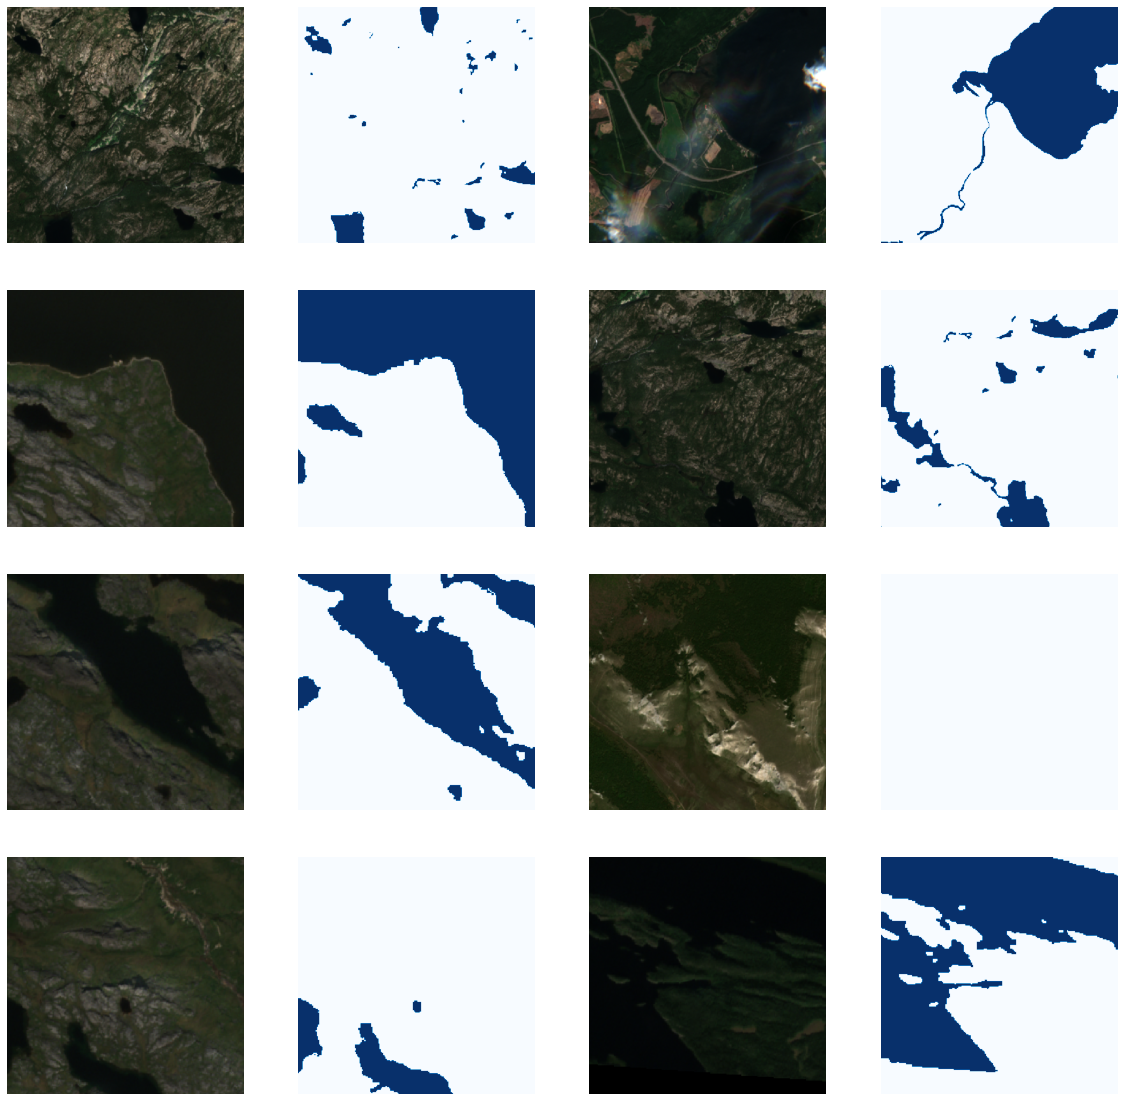

In [ ]:
plot_batch(train_batch)

## Data Standardization and Spectral Indices

Normally, machine learning methods (deep learning included) benefit from feature scaling. That means standard deviation around 1 and zero mean, by applying the following formula:
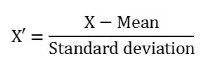

To do that, we need to first find the mean and standard deviation for each one of the 6s channels in the dataset.

Let’s define a function calculate these statistics and write its results in the variables mean and std. We will use our previously installed rasterio package to open the images and perform a simple average over the statistics for each batch/channel. For the standard deviation, this method is an approximation. For a more precise calculation, please refer to: http://notmatthancock.github.io/2017/03/23/simple-batch-stat-updates.htm.

In [ ]:
def calc_statistics(dset: RasterDataset):
        """
        Calculate the statistics (mean and std) for the entire dataset
        Warning: This is an approximation. The correct value should take into account the
        mean for the whole dataset for computing individual stds.
        For correctness I suggest checking: http://notmatthancock.github.io/2017/03/23/simple-batch-stat-updates.html
        """

        # To avoid loading the entire dataset in memory, we will loop through each img
        # The filenames will be retrieved from the dataset's rtree index
        files = [item.object for item in dset.index.intersection(dset.index.bounds, objects=True)]

        # Reseting statistics
        accum_mean = 0
        accum_std = 0

        for file in files:
            img = rio.open(file).read()/10000 #type: ignore
            accum_mean += img.reshape((img.shape[0], -1)).mean(axis=1)
            accum_std += img.reshape((img.shape[0], -1)).std(axis=1)

        # at the end, we shall have 2 vectors with lenght n=chnls
        # we will average them considering the number of images
        return accum_mean / len(files), accum_std / len(files)

In [ ]:
class MyNormalize(torch.nn.Module):
    def __init__(self, mean: List[float], stdev: List[float]):
        super().__init__()

        self.mean = torch.Tensor(mean)[:, None, None]
        self.std = torch.Tensor(stdev)[:, None, None]

    def forward(self, inputs: dict):

        x = inputs["image"][..., : len(self.mean), :, :]

        # if batch
        if inputs["image"].ndim == 4:
            x = (x - self.mean[None, ...]) / self.std[None, ...]

        else:
            x = (x - self.mean) / self.std

        inputs["image"][..., : len(self.mean), :, :] = x

        return inputs

    def revert(self, inputs: dict):
        """
        De-normalize the batch.

        Args:
            inputs (dict): Dictionary with the 'image' key
        """

        x = inputs["image"][..., : len(self.mean), :, :]

        # if batch
        if x.ndim == 4:
            x = inputs["image"][:, : len(self.mean), ...]
            x = x * self.std[None, ...] + self.mean[None, ...]
        else:
            x = x * self.std + self.mean

        inputs["image"][..., : len(self.mean), :, :] = x

        return inputs


In [ ]:
normalize = MyNormalize(*calc_statistics(train_imgs))

tfms = torch.nn.Sequential(
    indices.AppendNDWI(index_green=1, index_nir=3),
    indices.AppendNDWI(index_green=1, index_nir=5),
    indices.AppendNDVI(index_nir=3, index_red=2),
    normalize
)

In [ ]:
transformed_batch = tfms(train_batch)
print(transformed_batch['image'].shape, transformed_batch['mask'].shape)

torch.Size([8, 9, 512, 512]) torch.Size([8, 1, 512, 512])


Note that our transformed batch has now 9 channels, instead of 6.

> Important: the normalize method we created will apply the normalization just to the original bands and it will ignore the previously appended indices. That’s important to avoid errors due to distinct shapes between the batch and the mean and std vectors.

## Segmentation Model

For the semantic segmentation model, we are going to use a predefined architecture that is available in Pytorch. Looking at list (https://pytorch.org/vision/stable/models.html#semantic-segmentation) it is possible to note 3 models available for semantic segmentation, but one (LRASPP) is intended for mobile applications. In our tutorial, we will use the DeepLabV3 model.

Here, we will create a DeepLabV3 model for 2 classes. In this case, I will skip the pretrained weights, as the weights represent another domain (not water segmentation from multispectral imagery).

In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet50
model = deeplabv3_resnet50(weights=None, num_classes=2)

model

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

The first thing we have to pay attention in the model architecture is the number of channels expected in the first convolution (Conv2d), that is defined as 3. That’s because the model is prepared to work with RGB images. After the first convolution, the 3 channels will produce 64 channels in lower resolution, and so on. As we have now 9 channels, we will change this first processing layer to adapt correctly to our model. We can do this by replacing the first convolutional layer for a new one, by following the commands. Finally, we check a mock batch can pass through the model and provide the output with 2 channels (water / no_water) as desired.

In [ ]:
backbone = model.get_submodule('backbone')

conv = torch.nn.modules.conv.Conv2d(
    in_channels=9, 
    out_channels=64, 
    kernel_size=(7, 7),
    stride=(2, 2),
    padding=(3, 3),
    bias=False
)
backbone.register_module('conv1', conv)

pred = model(torch.randn(3, 9, 512, 512))
pred['out'].shape

torch.Size([3, 2, 512, 512])

## Training Loop

The training function should receive the number of epochs, the model, the dataloaders, the loss function (to be optimized) the accuracy function (to assess the results), the optimizer (that will adjust the parameters of the model in the correct direction) and the transformations to be applied to each batch.

In [ ]:
def train_loop(
    epochs: int, 
    train_dl: DataLoader, 
    val_dl: Optional[DataLoader], 
    model: torch.nn.Module, 
    loss_fn: Callable, 
    optimizer: torch.optim.Optimizer, 
    acc_fns: Optional[List]=None, 
    batch_tfms: Optional[Callable]=None
):
    # size = len(dataloader.dataset)
    cuda_model = model.cuda()

    for epoch in range(epochs):
        accum_loss = 0
        for batch in train_dl:

            if batch_tfms is not None:
                batch = batch_tfms(batch)

            X = batch['image'].cuda()
            y = batch['mask'].type(torch.long).cuda()
            pred = cuda_model(X)['out']
            loss = loss_fn(pred, y)

            # BackProp
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update the accum loss
            accum_loss += float(loss) / len(train_dl)

        # Testing against the validation dataset
        if acc_fns is not None and val_dl is not None:
            # reset the accuracies metrics
            acc = [0.] * len(acc_fns)

            with torch.no_grad():
                for batch in val_dl:

                    if batch_tfms is not None:
                        batch = batch_tfms(batch)                    

                    X = batch['image'].type(torch.float32).cuda()
                    y = batch['mask'].type(torch.long).cuda()

                    pred = cuda_model(X)['out']

                    for i, acc_fn in enumerate(acc_fns):
                        acc[i] = float(acc[i] + acc_fn(pred, y)/len(val_dl))

            # at the end of the epoch, print the errors, etc.
            print(f'Epoch {epoch}: Train Loss={accum_loss:.5f} - Accs={[round(a, 3) for a in acc]}')
        else:

            print(f'Epoch {epoch}: Train Loss={accum_loss:.5f}')

## Loss and Accuracy Functions

For the loss function, normally the Cross Entropy Loss should work, but it requires the mask to have shape (N, d1, d2). In this case, we will need to squeeze our second dimension manually.

In [ ]:
from sklearn.metrics import jaccard_score

def oa(pred, y):
    flat_y = y.squeeze()
    flat_pred = pred.argmax(dim=1)
    acc = torch.count_nonzero(flat_y == flat_pred) / torch.numel(flat_y)
    return acc

def iou(pred, y):
    flat_y = y.cpu().numpy().squeeze()
    flat_pred = pred.argmax(dim=1).detach().cpu().numpy()
    return jaccard_score(flat_y.reshape(-1), flat_pred.reshape(-1), zero_division=1.)    

def loss(p, t):    
    return torch.nn.functional.cross_entropy(p, t.squeeze())

## Training

> To train the model it is important to have CUDA GPUs available. In Colab, it can be done by changing the runtime type and re-running the notebook. 

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)
train_loop(15, train_dataloader, valid_dataloader, model, loss, optimizer, 
           acc_fns=[oa, iou], batch_tfms=tfms)

Epoch 0: Train Loss=0.56375 - Accs=[0.926, 0.612]
Epoch 1: Train Loss=0.31368 - Accs=[0.936, 0.625]
Epoch 2: Train Loss=0.28641 - Accs=[0.938, 0.734]
Epoch 3: Train Loss=0.22545 - Accs=[0.964, 0.72]
Epoch 4: Train Loss=0.19243 - Accs=[0.951, 0.724]
Epoch 5: Train Loss=0.19754 - Accs=[0.97, 0.825]
Epoch 6: Train Loss=0.16495 - Accs=[0.962, 0.845]
Epoch 7: Train Loss=0.18088 - Accs=[0.964, 0.762]
Epoch 8: Train Loss=0.16766 - Accs=[0.975, 0.84]
Epoch 9: Train Loss=0.21383 - Accs=[0.961, 0.813]
Epoch 10: Train Loss=0.20510 - Accs=[0.972, 0.868]
Epoch 11: Train Loss=0.14746 - Accs=[0.984, 0.903]
Epoch 12: Train Loss=0.16619 - Accs=[0.969, 0.844]
Epoch 13: Train Loss=0.10504 - Accs=[0.972, 0.85]
Epoch 14: Train Loss=0.09735 - Accs=[0.977, 0.853]
